In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

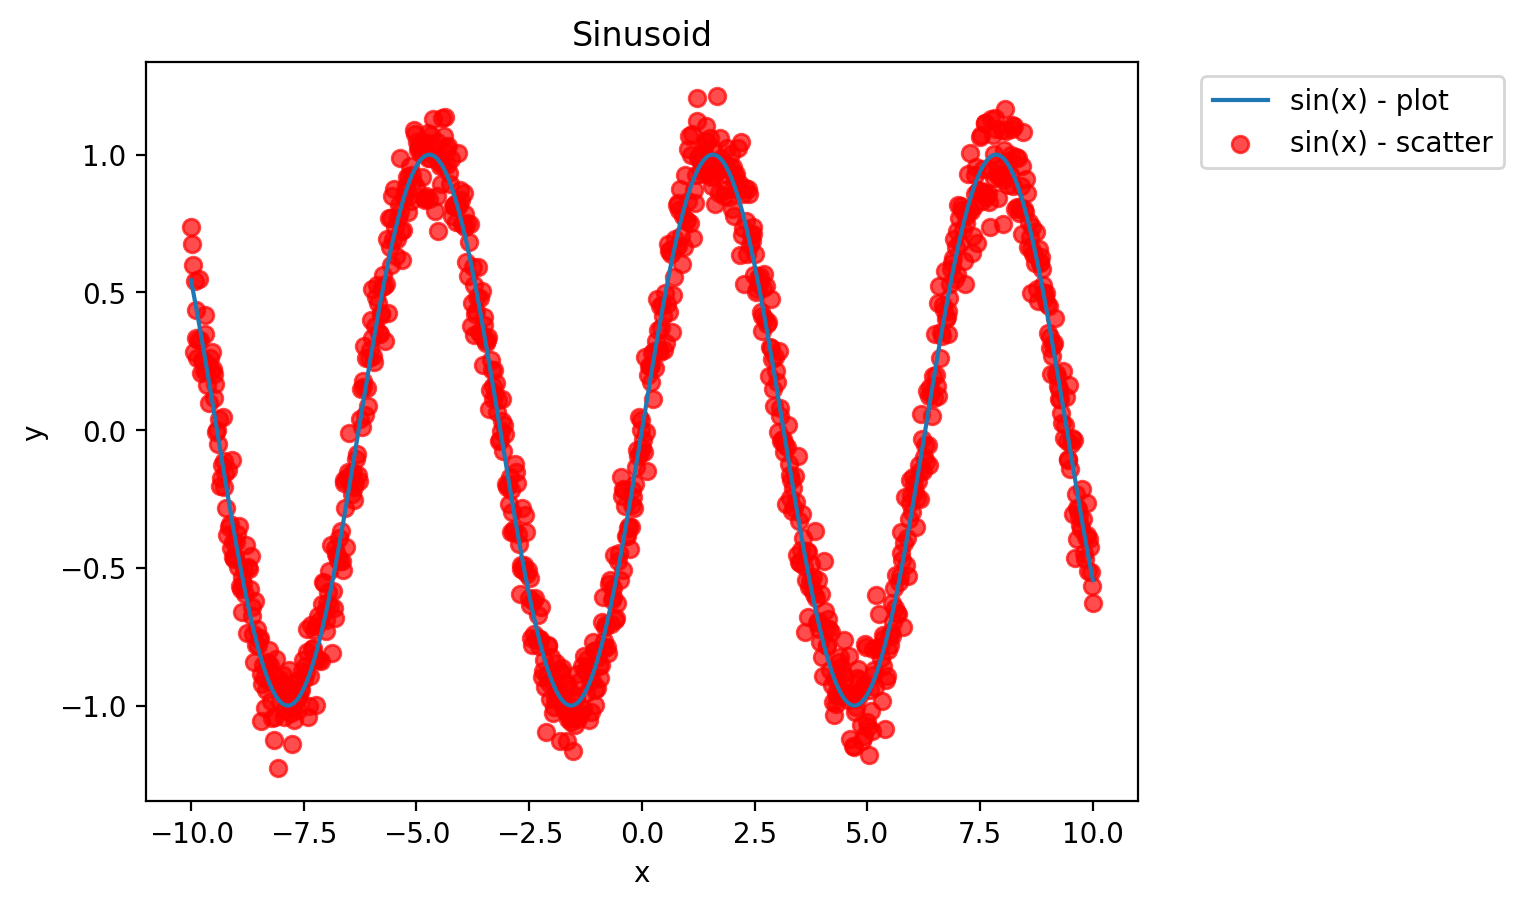

In [2]:
n_points = 1000

x = torch.linspace(-10, 10, n_points)


y = torch.sin(x) + torch.randn(n_points) * 0.1
plt.plot(x, torch.sin(x) );
plt.scatter(x, y, c = 'red', alpha = 0.7);
plt.title('Sinusoid');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x) - plot', 'sin(x) - scatter'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [3]:
x = StandardScaler().fit_transform(x.reshape(-1, 1))
y = StandardScaler().fit_transform(y.reshape(-1, 1))
x = torch.tensor(x, dtype=torch.float32).squeeze()
y = torch.tensor(y, dtype=torch.float32).squeeze()

In [4]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4, shuffle=True)

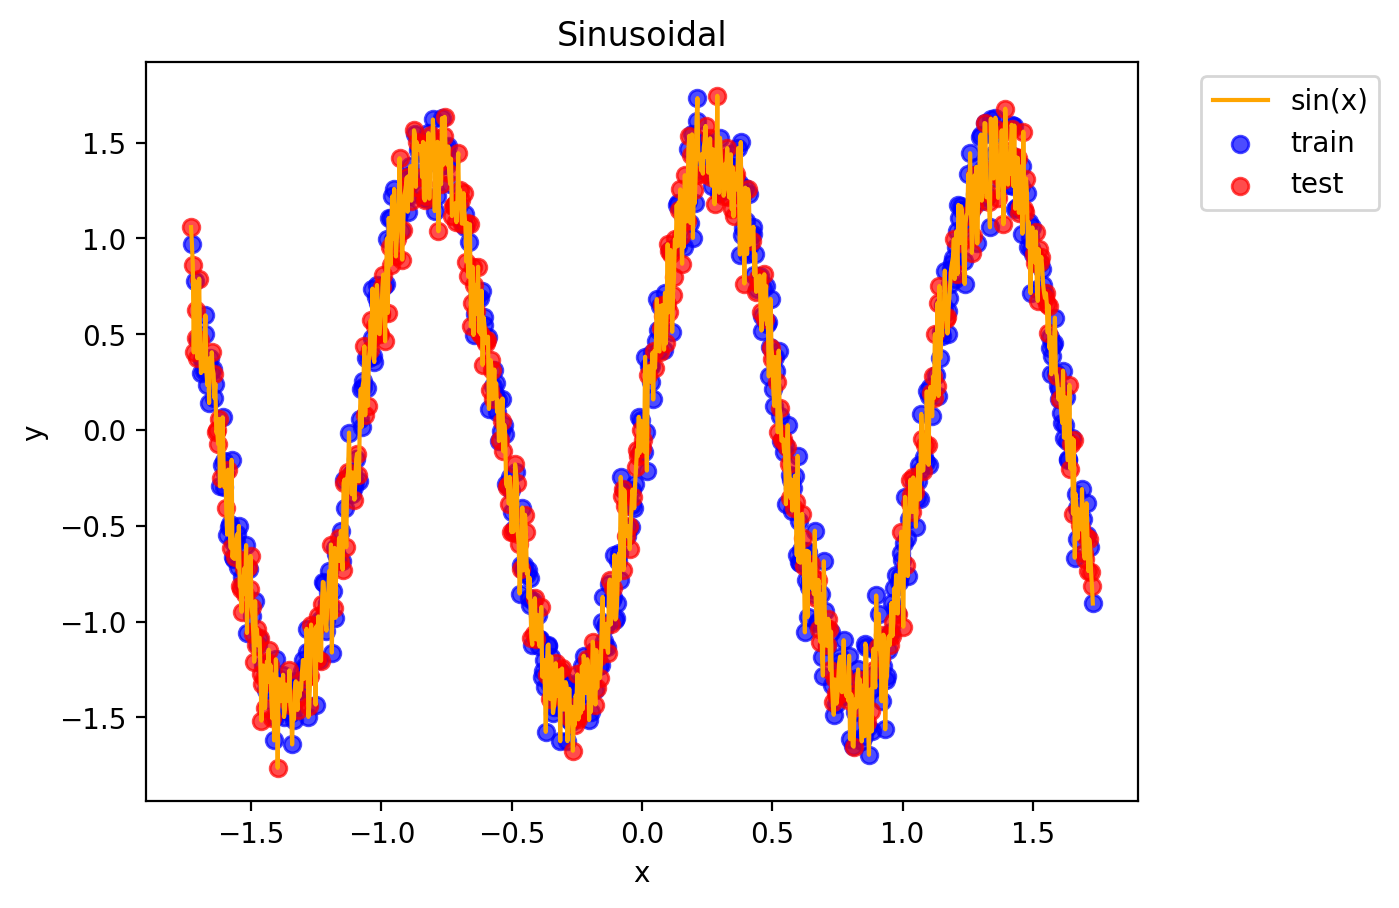

In [5]:
plt.plot(x, y, color = 'orange');
plt.scatter(train_x, train_y, c = 'blue', alpha = 0.7);
plt.scatter(test_x, test_y, c='red', alpha = 0.7);
plt.title('Sinusoidal');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(['sin(x)', 'train', 'test'],bbox_to_anchor=(1.05, 1.0), loc='upper left');

In [6]:
train_x = train_x.unsqueeze(0).unsqueeze(0)
train_y = train_y.unsqueeze(0).unsqueeze(0)
test_x = test_x.unsqueeze(0).unsqueeze(0)
test_y = test_y.unsqueeze(0).unsqueeze(0)

In [7]:
import torch.nn.functional as F

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_channels, kernel_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size, dilation=2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv1d(num_channels, num_channels, kernel_size, dilation=4)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.conv4 = nn.Conv1d(num_channels, output_size, kernel_size)
        self.kernel_size = kernel_size

    def forward(self, x):
        x = F.pad(x, ((self.kernel_size - 1)*1,0))
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.pad(x, ((self.kernel_size - 1)*1,0))
        x = self.conv4(x)
        return x


In [8]:
input_size = 1  
output_size = 1  
num_channels = 32 
kernel_size = 3  
dropout = 0.2  

In [9]:
model = TCN(input_size, output_size, num_channels, kernel_size, dropout)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 1000/1000 [00:02<00:00, 463.60it/s]


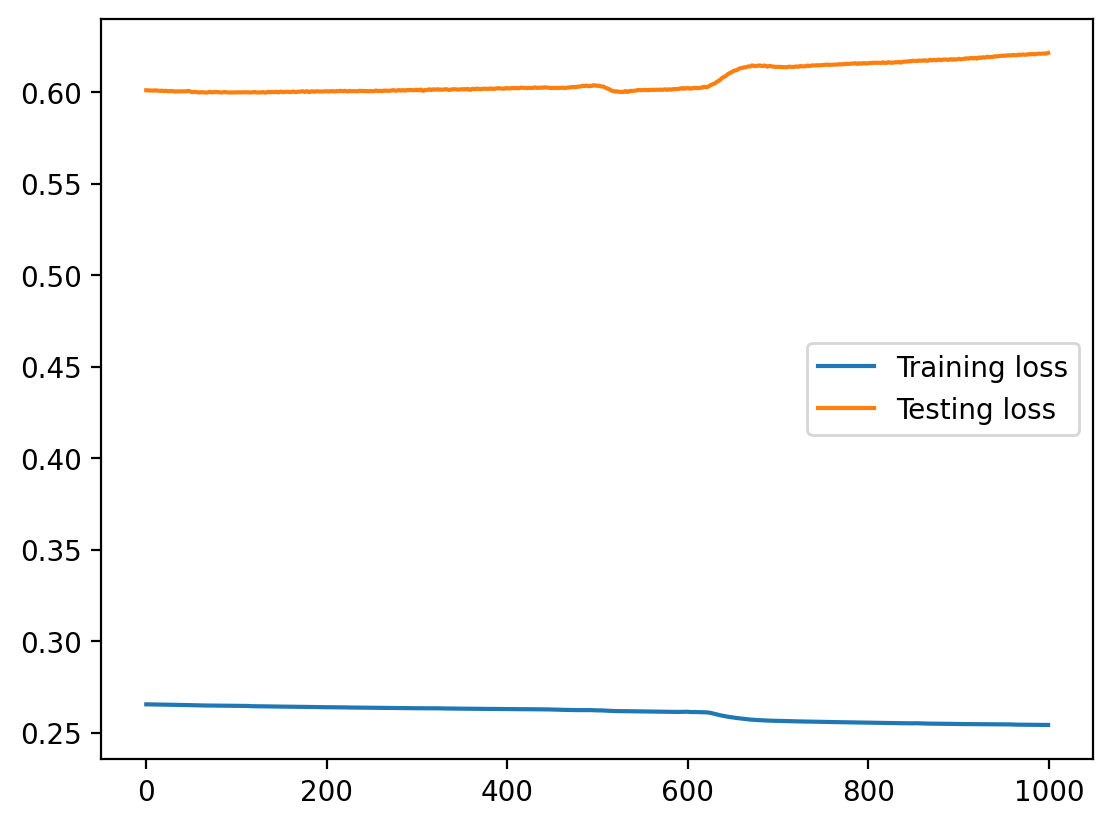

In [20]:
# write training and testing loops without function don't devide in batches
epochs = 1000
train_losses = []
test_losses = []
for i in tqdm(range(epochs)):
    y_pred = model(train_x)
    loss = criterion(y_pred.squeeze(), train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    with torch.no_grad():
        y_val = model(test_x)
        loss = criterion(y_val.squeeze(), test_y)
        test_losses.append(loss.item())

# Plot the training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend();

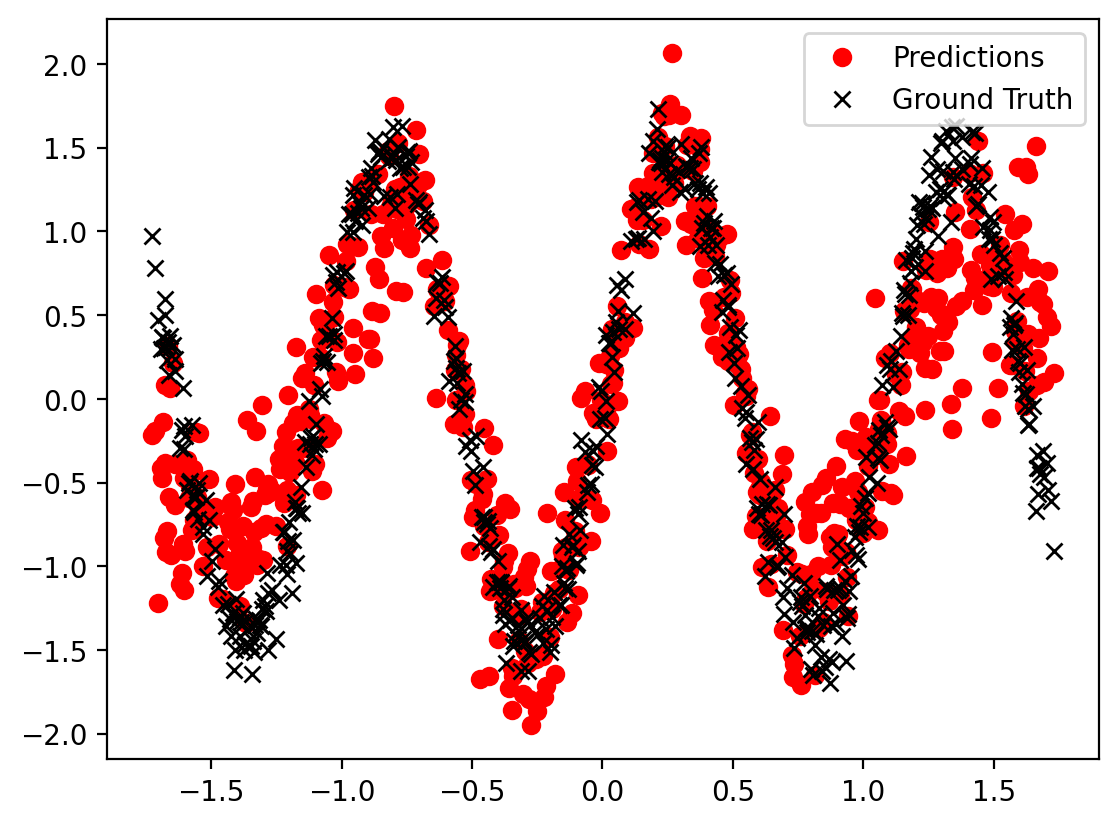

In [21]:
# plot the prediction on train and add legends also
with torch.no_grad():
    preds = model(train_x)
    preds = preds.detach().numpy()
    plt.plot(train_x.squeeze(), preds.squeeze(), 'ro', label='Predictions')
    plt.plot(train_x.squeeze(), train_y.squeeze(), 'kx', label='Ground Truth')
    plt.legend();

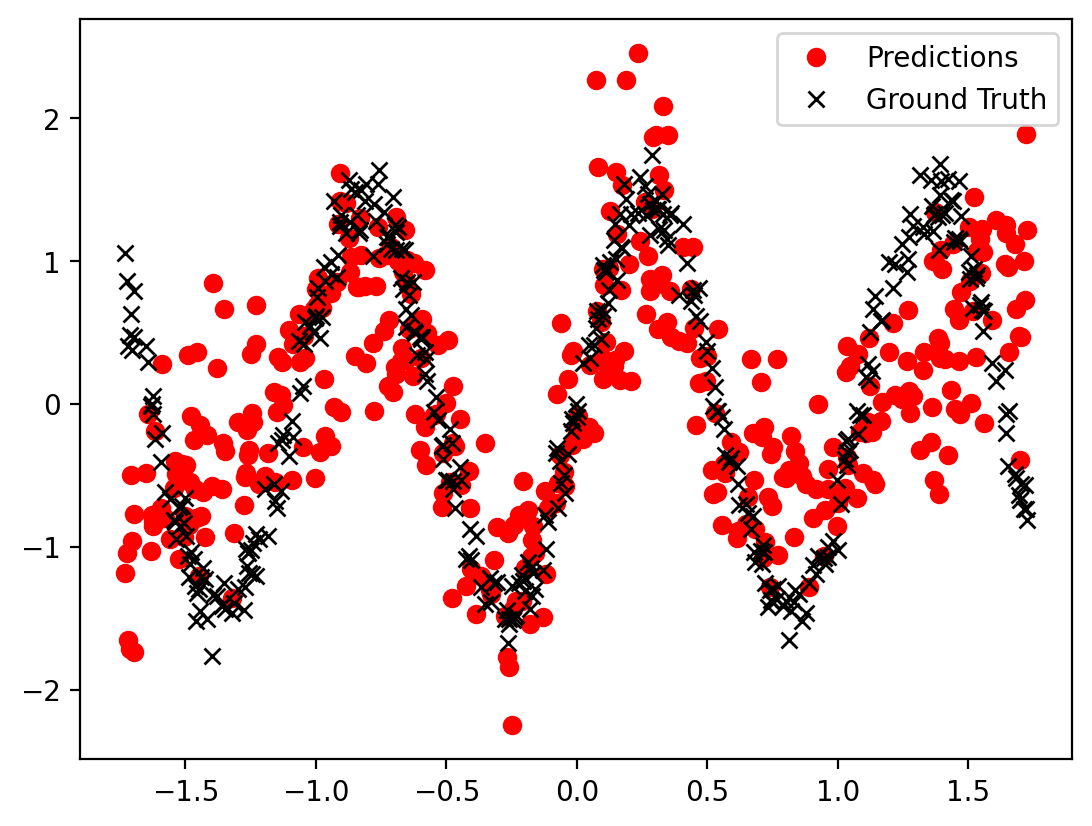

In [22]:
# plot the prediction and add legends also
with torch.no_grad():
    preds = model(test_x)
    preds = preds.detach().numpy()
    plt.plot(test_x.squeeze(), preds.squeeze(), 'ro', label='Predictions')
    plt.plot(test_x.squeeze(), test_y.squeeze(), 'kx', label='Ground Truth')
    plt.legend();